In [1]:
# io
import os
from pathlib import Path

# mathematics
import numpy as np
import pandas as pd
import math
from math import exp

# thermal
import  CoolProp.CoolProp as CP
from CoolProp.HumidAirProp import HAPropsSI
import psychrolib as psylib
psylib.SetUnitSystem(psylib.SI)

import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.insert(0, os.path.join('./../..','calibration'))
from thermodynamics import *
import media_model_mgcl2 as model_mg
import media_model_water as model_w

# **DemPav Data**

In [20]:
df_raw_dempav = pd.read_excel("../exp_data/dempav_results_Aug_final_2020.xlsx", index_col=0)

In [21]:
df_raw_dempav['x_d_in_equ'] = np.vectorize(calc_x_des_equ)(df_raw_dempav.T_d_in, df_raw_dempav.xi_d_in)

In [22]:
df_raw_dempav

,T_a_in,hr_air_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
0,298.02,48.26,0.018848,287.44,0.318302,0.102670,290.21,47.90,286.230,0.009457,0.005773,0.004515
1,300.51,55.58,0.036283,292.20,0.318186,0.102670,294.81,54.06,290.092,0.012683,0.008716,0.006170
2,298.02,46.07,0.032644,284.16,0.318572,0.102670,287.98,50.83,281.766,0.009022,0.005308,0.003614
3,301.31,50.70,0.036150,290.94,0.318174,0.102669,293.69,52.19,288.468,0.012112,0.007844,0.005687
4,299.87,42.59,0.045742,290.34,0.318171,0.102668,292.89,52.75,288.366,0.009311,0.007542,0.005470
5,301.71,43.11,0.050290,292.12,0.318252,0.102675,297.38,40.59,289.957,0.010514,0.007633,0.006136
6,302.39,49.11,0.050221,293.32,0.318283,0.102676,300.51,42.09,291.612,0.012498,0.009558,0.006625
7,301.99,44.94,0.018140,294.30,0.343938,0.104834,296.50,33.44,293.038,0.011151,0.005948,0.005988
8,308.02,28.68,0.033955,298.14,0.344078,0.104832,299.94,37.70,296.535,0.009994,0.008262,0.007611
9,295.22,65.24,0.037419,297.52,0.318444,0.102671,296.66,49.51,297.085,0.010821,0.008935,0.008623


# **Teststand**

## convert raw data table

In [4]:
df_raw = pd.read_excel("../../exp_data/raw/teststand_results_old.xlsx", index_col=0, header=[0,1])
df_raw.columns = df_raw.columns.droplevel(1)
df_raw.shape

(62, 16)

In [5]:
df_raw.head()

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,w_air_in,w_air_out,x_a_in,x_a_o_exp
0,23.89,87.20,46.52,NaN,25.06,NaN,1.31,1292.0,NaN,28.12,51.24,25.69,NaN,NaN,NaN,NaN
1,26.77,79.81,47.22,NaN,27.76,NaN,1.28,1289.0,NaN,30.25,50.93,28.44,NaN,NaN,NaN,NaN
2,26.79,83.82,19.50,NaN,27.14,NaN,1.18,1292.0,NaN,30.37,49.44,27.83,NaN,NaN,NaN,NaN
3,27.34,75.69,18.49,NaN,28.70,NaN,0.75,1290.0,NaN,30.89,46.88,29.33,NaN,NaN,NaN,NaN
4,28.43,86.59,18.90,NaN,30.25,NaN,0.22,1290.0,NaN,33.57,49.14,31.43,NaN,NaN,NaN,NaN


In [6]:
df_raw.m_a_in = df_raw.V_a_in * np.vectorize(get_rho_dry)(df_raw.T_a_in+273.15, df_raw.hr_air_in/100) / 3600

In [7]:
df_raw.x_a_in = np.vectorize(get_x)(df_raw.T_a_in+273.15, df_raw.hr_air_in/100)

In [8]:
df_raw.x_a_o_exp = np.vectorize(get_x)(df_raw.T_a_o_exp+273.15, df_raw.hr_air_out/100)

In [10]:
df_raw.xi_d_in = np.vectorize(model_mg.xi_MgCl2)(df_raw.T_a_in+273.15, df_raw.rho_d_in)

In [11]:
df_raw.T_a_in = df_raw.T_a_in + 273.15
df_raw.T_d_in = df_raw.T_d_in + 273.15
df_raw.T_a_o_exp = df_raw.T_a_o_exp + 273.15
df_raw.T_d_o_exp = df_raw.T_d_o_exp + 273.15

In [12]:
df_raw.m_d_in = df_raw.V_d_in/1000/60 * df_raw.rho_d_in

In [13]:
df_raw['x_d_in_equ'] = np.vectorize(calc_x_des_equ)(df_raw.T_d_in, df_raw.xi_d_in)

In [18]:
df_raw.drop(columns=['w_air_in', 'w_air_out'], inplace = True)

In [14]:
df_raw.head()

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,w_air_in,w_air_out,x_a_in,x_a_o_exp,x_d_in_equ
0,297.04,87.20,46.52,0.014969,298.21,0.313764,1.31,1292.0,0.028209,301.27,51.24,298.84,NaN,NaN,0.016362,0.012271,0.009253
1,299.92,79.81,47.22,0.015014,300.91,0.311185,1.28,1289.0,0.027499,303.40,50.93,301.59,NaN,NaN,0.017815,0.013828,0.011082
2,299.94,83.82,19.50,0.006191,300.29,0.314032,1.18,1292.0,0.025409,303.52,49.44,300.98,NaN,NaN,0.018759,0.013509,0.010496
3,300.49,75.69,18.49,0.005871,301.85,0.312199,0.75,1290.0,0.016125,304.04,46.88,302.48,NaN,NaN,0.017460,0.013190,0.011662
4,301.58,86.59,18.90,0.005943,303.40,0.312333,0.22,1290.0,0.004730,306.72,49.14,304.58,NaN,NaN,0.021418,0.016161,0.012790


## split to absorption and regeneration

In [32]:
df_raw.head()

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
0,297.04,87.20,46.52,0.014969,298.21,0.313764,1.31,1292.0,0.028209,301.27,51.24,298.84,0.016362,0.012271,0.009253
1,299.92,79.81,47.22,0.015014,300.91,0.311185,1.28,1289.0,0.027499,303.40,50.93,301.59,0.017815,0.013828,0.011082
2,299.94,83.82,19.50,0.006191,300.29,0.314032,1.18,1292.0,0.025409,303.52,49.44,300.98,0.018759,0.013509,0.010496
3,300.49,75.69,18.49,0.005871,301.85,0.312199,0.75,1290.0,0.016125,304.04,46.88,302.48,0.017460,0.013190,0.011662
4,301.58,86.59,18.90,0.005943,303.40,0.312333,0.22,1290.0,0.004730,306.72,49.14,304.58,0.021418,0.016161,0.012790


In [29]:
df_raw_cool = df_raw.query('T_a_in > T_d_in')
df_raw_cool.shape

(36, 15)

In [34]:
df_raw_cool

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
5,309.87,73.36,19.62,0.005931,306.88,0.309043,0.22,1285.00,0.004712,312.67,51.09,309.24,0.029307,0.023538,0.016016
9,300.60,71.77,39.00,0.012395,299.21,0.304608,1.33,1282.00,0.028418,302.29,50.71,300.15,0.016642,0.012897,0.010371
14,301.82,72.60,41.56,0.013125,301.62,0.295215,0.67,1272.00,0.014204,304.20,51.54,302.80,0.018116,0.014668,0.012646
15,302.70,89.30,21.94,0.006850,298.58,0.296304,1.37,1273.00,0.029067,304.26,56.40,299.81,0.023650,0.016143,0.010444
16,301.56,84.26,23.01,0.007243,299.66,0.296136,0.95,1273.00,0.020156,304.20,53.98,300.79,0.020798,0.015379,0.011170
29,304.36,90.69,19.15,0.005920,278.89,0.307050,1.08,1284.00,0.023112,300.27,68.89,281.04,0.026531,0.015643,0.002681
30,298.82,87.98,47.91,0.015275,279.99,0.301540,1.05,1279.00,0.022383,297.83,63.22,283.08,0.018420,0.012360,0.002990
33,300.89,89.28,18.94,0.005971,280.90,0.316032,0.57,1294.00,0.012293,299.50,59.66,283.35,0.021207,0.012891,0.002930
34,300.63,66.83,40.55,0.012909,280.34,0.309369,0.56,1287.00,0.012012,297.92,56.36,283.28,0.015496,0.011055,0.002931
35,301.47,68.80,47.34,0.014999,280.38,0.304720,0.66,1282.00,0.014102,299.35,58.38,284.09,0.016788,0.012496,0.003018


In [28]:
df_raw_absorption = df_raw.query('x_a_in > x_a_o_exp')
df_raw_absorption.shape

(58, 15)

In [36]:
df_raw_regeneration

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
17,304.65,12.55,69.81,0.022346,309.03,0.310888,1.31,1288.0,0.028121,302.62,28.18,307.20,0.003601,0.007240,0.017959
31,308.69,20.16,62.51,0.019631,311.41,0.314454,1.34,1291.0,0.028832,306.34,32.53,310.19,0.007294,0.010378,0.020168
32,306.20,32.67,62.51,0.019696,311.06,0.313041,1.24,1290.0,0.026660,307.20,38.06,308.45,0.010340,0.012789,0.019933
38,309.92,13.89,78.85,0.024740,309.67,0.309998,1.34,1286.0,0.028721,306.03,28.63,308.28,0.005360,0.008956,0.018731


In [30]:
df_raw_regeneration = df_raw.query('x_a_in < x_a_o_exp')
df_raw_regeneration.shape

(4, 15)

In [33]:
df_raw.query('x_d_in_equ>x_a_in')

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
17,304.65,12.55,69.81,0.022346,309.03,0.310888,1.31,1288.0,0.028121,302.62,28.18,307.20,0.003601,0.007240,0.017959
31,308.69,20.16,62.51,0.019631,311.41,0.314454,1.34,1291.0,0.028832,306.34,32.53,310.19,0.007294,0.010378,0.020168
32,306.20,32.67,62.51,0.019696,311.06,0.313041,1.24,1290.0,0.026660,307.20,38.06,308.45,0.010340,0.012789,0.019933
38,309.92,13.89,78.85,0.024740,309.67,0.309998,1.34,1286.0,0.028721,306.03,28.63,308.28,0.005360,0.008956,0.018731


In [41]:
df_raw_heat = df_raw.query('T_d_in-T_a_in > 2')

In [42]:
df_raw_heat

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
11,300.22,79.59,16.35,0.005191,304.63,0.299788,1.44,1277.0,0.030648,304.73,47.42,304.85,0.018089,0.013891,0.014773
12,300.80,73.22,16.45,0.005220,304.67,0.299861,0.68,1277.0,0.014473,304.59,47.67,304.97,0.017193,0.013853,0.014802
17,304.65,12.55,69.81,0.022346,309.03,0.310888,1.31,1288.0,0.028121,302.62,28.18,307.20,0.003601,0.007240,0.017959
21,301.47,82.73,20.41,0.006431,303.90,0.311371,0.16,1289.0,0.003437,306.62,47.75,305.30,0.020298,0.015602,0.013252
22,302.13,84.09,31.33,0.009833,304.40,0.311458,0.16,1289.0,0.003437,307.41,49.43,306.09,0.021476,0.016914,0.013645
23,301.04,87.26,30.88,0.009735,304.84,0.309419,0.37,1287.0,0.007936,306.48,50.26,306.78,0.020899,0.016312,0.014172
24,301.71,86.25,31.16,0.009793,305.35,0.309506,0.65,1287.0,0.013943,306.87,50.31,306.31,0.021499,0.016699,0.014599
25,301.77,72.59,44.56,0.014076,305.74,0.309513,0.20,1287.0,0.004290,305.55,48.44,306.65,0.018060,0.014887,0.014938
26,302.78,85.64,31.56,0.009864,306.34,0.304905,0.20,1282.0,0.004273,308.21,50.33,308.42,0.022753,0.018035,0.015885
28,302.14,88.91,19.17,0.006004,306.46,0.303860,0.25,1281.0,0.005338,308.44,48.34,308.99,0.022766,0.017530,0.016091


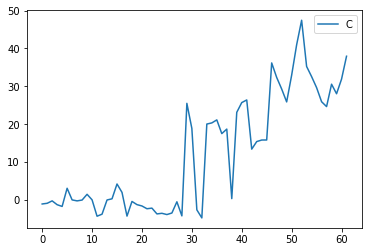

In [37]:
(df_raw.T_a_in - df_raw.T_d_in).plot()

In [43]:
calc_x_des_equ(T_des=311.06, xi_des = 0.313, type_desiccant='LiCl')

0.016598107787442144

In [44]:
calc_x_des_equ(T_des=311.06, xi_des = 0.313, type_desiccant='MgCl2')

0.019937677174607284